<a href="https://colab.research.google.com/github/s34836/WUM/blob/main/Lab_12_Object_Classification_and_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Classification and Localization

## Tasks
1. See an example of a network designed to classify and localize objects [here](https://github.com/camara94/object-localization-tensorflow/blob/main/project/Object_Localization_with_TensorFlow_Complete.ipynb).
2. The `CALTECH.zip` file contains a dataset of images dividend into three classes and with assigned bounding boxes (in `labels.csv`). Load the images, labels and bounding box coordinates. To classify the images and localize objects, create a convolutional network with two output layers - one for classes and one for coordinates. Due to limited training data, for this task it is best to use a pre-trained model, for example MobileNetV2.

In [1]:

!unzip -q CALTECH.zip
!ls

CALTECH  CALTECH.zip  sample_data


In [13]:

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

images = tf.keras.preprocessing.image_dataset_from_directory("CALTECH/CALTECH_Dataset", shuffle=False, label_mode=None, batch_size=None, image_size=(224, 224))
images = np.stack([image.numpy() for image in images])
images = (images / 255.0) * 2.0 - 1.0  # Scale images to [-1, 1]

# Load and scale bounding boxes
labels = pd.read_csv("CALTECH/labels.csv")
im_width = labels['width']
im_height = labels['height']
bounding_boxes = labels.iloc[:, -4:]
bounding_boxes['xmin'] = bounding_boxes['xmin'] / im_width
bounding_boxes['xmax'] = bounding_boxes['xmax'] / im_width
bounding_boxes['ymin'] = bounding_boxes['ymin'] / im_height
bounding_boxes['ymax'] = bounding_boxes['ymax'] / im_height
bounding_boxes = bounding_boxes.to_numpy()

class_targets = labels['class'].astype('category').cat.codes.to_numpy()

X_train, X_test, bbox_train, bbox_test, labels_train, labels_test = train_test_split(images, bounding_boxes, class_targets, test_size=0.2, random_state=42)

Found 218 files.


In [23]:
#Importy + wczytanie labels.csv + przygotowanie ścieżek do obrazów

# Ścieżki (dopasuj jeśli masz inaczej)
DATA_DIR = "CALTECH/CALTECH_Dataset"
LABELS_PATH = "CALTECH/labels.csv"

labels = pd.read_csv(LABELS_PATH)

# --- znajdź kolumnę z nazwą pliku (jeśli istnieje) ---
possible_name_cols = ["filename", "file", "image", "img", "path", "name"]
name_col = next((c for c in possible_name_cols if c in labels.columns), None)

# --- zbuduj listę plików obrazów ---
def to_full_path(x):
    return glob.glob(f"{DATA_DIR}/**/{x}", recursive=True)[0]
filepaths = labels[name_col].apply(to_full_path).tolist()


filepaths = np.array(filepaths)
print("Images:", len(filepaths))
print("labels.csv rows:", len(labels))

Images: 218
labels.csv rows: 218


In [24]:
# Klasy + bbox (normalizacja do [0,1])

# kolumny bbox: zakładamy klasyczne xmin,ymin,xmax,ymax w ostatnich 4 kolumnach jak w przykładzie
bbox = labels.iloc[:, -4:].copy()

# normalizacja wg width/height (jak w Twoim przykładzie)
im_width = labels["width"].astype(np.float32).to_numpy()
im_height = labels["height"].astype(np.float32).to_numpy()

bbox["xmin"] = bbox["xmin"] / im_width
bbox["xmax"] = bbox["xmax"] / im_width
bbox["ymin"] = bbox["ymin"] / im_height
bbox["ymax"] = bbox["ymax"] / im_height

bbox = bbox.to_numpy().astype(np.float32)
bbox = np.clip(bbox, 0.0, 1.0)

# klasy -> kody 0..K-1
class_ids = labels["class"].astype("category").cat.codes.to_numpy().astype(np.int32)
num_classes = int(labels["class"].astype("category").cat.categories.shape[0])
print("num_classes:", num_classes)

num_classes: 3


In [25]:
# tf.data: wczytanie obrazów, resize, normalizacja do [-1,1], batching

IMG_SIZE = (224, 224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, cls, bb):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    # MobileNetV2: [-1, 1]
    img = (img / 255.0) * 2.0 - 1.0
    return img, {"class_out": cls, "bbox_out": bb}

X_train, X_test, ycls_train, ycls_test, ybb_train, ybb_test = train_test_split(
    filepaths, class_ids, bbox, test_size=0.2, random_state=42, stratify=class_ids
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, ycls_train, ybb_train))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, ycls_test, ybb_test))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

In [26]:
#Model: MobileNetV2 + 2 wyjścia (klasa + bbox)

base = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg",
)
base.trainable = False  # najprościej: zamrażamy na start

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base(inputs, training=False)

# głowica klasyfikacji
class_out = tf.keras.layers.Dense(num_classes, activation="softmax", name="class_out")(x)

# głowica bbox (0..1)
bbox_out = tf.keras.layers.Dense(4, activation="sigmoid", name="bbox_out")(x)

model = tf.keras.Model(inputs, outputs={"class_out": class_out, "bbox_out": bbox_out})

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "class_out": tf.keras.losses.SparseCategoricalCrossentropy(),
        "bbox_out": tf.keras.losses.Huber(delta=0.05),  # stabilniejsze niż MSE przy małym zbiorze
    },
    loss_weights={"class_out": 1.0, "bbox_out": 5.0},  # bbox zwykle potrzebuje większej wagi
    metrics={
        "class_out": ["accuracy"],
        "bbox_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
    },
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ input_layer_7[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_out (Dense)    │ (None, 4)         │      5,124 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_out (Dense)   │ (None, 3)         │      3,843 │ mobilenetv2_1.00… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
# Trening + ewaluacja
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks,
)

model.evaluate(test_ds)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - bbox_out_loss: 0.0103 - bbox_out_mae: 0.2318 - class_out_accuracy: 0.4808 - class_out_loss: 1.0492 - loss: 1.1120 - val_bbox_out_loss: 0.0031 - val_bbox_out_mae: 0.0822 - val_class_out_accuracy: 0.8409 - val_class_out_loss: 0.5863 - val_loss: 0.5781
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - bbox_out_loss: 0.0030 - bbox_out_mae: 0.0801 - class_out_accuracy: 0.8469 - class_out_loss: 0.4934 - loss: 0.5150 - val_bbox_out_loss: 0.0029 - val_bbox_out_mae: 0.0736 - val_class_out_accuracy: 0.9318 - val_class_out_loss: 0.2681 - val_loss: 0.2922
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - bbox_out_loss: 0.0030 - bbox_out_mae: 0.0791 - class_out_accuracy: 0.9850 - class_out_loss: 0.2117 - loss: 0.2282 - val_bbox_out_loss: 0.0030 - val_bbox_out_mae: 0.0755 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.1525 - val_loss: 0.1658
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - bbox_out_loss: 0.0030 - bbox_out_mae: 0.0789 - clas

[0.04210784286260605,
 0.02619830146431923,
 0.0029198965057730675,
 0.07872781902551651,
 1.0]

['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
BBox columns assumed: ['xmin', 'ymin', 'xmax', 'ymax']

Sample 0
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.28033474), np.float32(0.06666667), np.float32(0.92050207), np.float32(0.9266667)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.059541445), np.float32(0.083917595), np.float32(0.9641142), np.float32(0.9381378)]


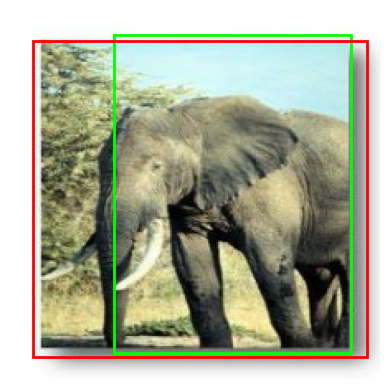


Sample 1
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.09677419), np.float32(0.046666667), np.float32(0.97235024), np.float32(0.87666667)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.0395621), np.float32(0.11897121), np.float32(0.82199275), np.float32(0.89561665)]


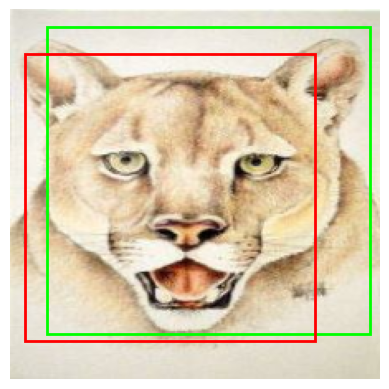


Sample 2
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.26), np.float32(0.12777779), np.float32(0.93333334), np.float32(0.98888886)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.08626206), np.float32(0.2369058), np.float32(0.9690472), np.float32(0.8893917)]


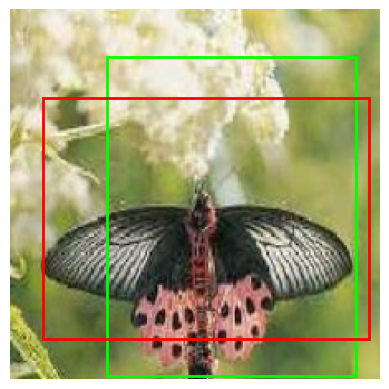


Sample 3
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.043333333), np.float32(0.1384083), np.float32(0.99333334), np.float32(0.9411765)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.02017296), np.float32(0.0984986), np.float32(0.9701679), np.float32(0.9549572)]


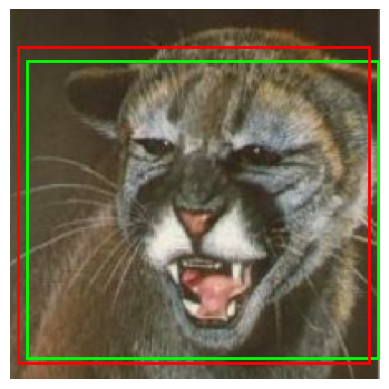

In [21]:
# kontrola predykcji bbox dla 1 batcha
import matplotlib.pyplot as plt

# pokaż nazwy kolumn, żeby zweryfikować kolejność bbox
print(labels.columns.tolist())
print("BBox columns assumed:", bbox.columns.tolist() if isinstance(bbox, pd.DataFrame) else labels.columns[-4:].tolist())

for images, targets in test_ds.take(1):
    preds = model.predict(images, verbose=0)

    pred_bb = preds["bbox_out"]
    true_bb = targets["bbox_out"].numpy()

    imgs = (images.numpy() + 1.0) / 2.0  # back to [0,1]

    for i in range(min(4, imgs.shape[0])):
        h, w = imgs[i].shape[0], imgs[i].shape[1]
        tx1, ty1, tx2, ty2 = true_bb[i]
        px1, py1, px2, py2 = pred_bb[i]

        print(f"\nSample {i}")
        print("TRUE bbox [xmin,ymin,xmax,ymax]:", [tx1, ty1, tx2, ty2])
        print("PRED bbox [xmin,ymin,xmax,ymax]:", [px1, py1, px2, py2])

        plt.figure()
        plt.imshow(imgs[i])
        plt.axis("off")

        # TRUE - zielony
        plt.gca().add_patch(
            plt.Rectangle((tx1*w, ty1*h), (tx2-tx1)*w, (ty2-ty1)*h,
                          fill=False, linewidth=2, edgecolor="lime")
        )
        # PRED - czerwony
        plt.gca().add_patch(
            plt.Rectangle((px1*w, py1*h), (px2-px1)*w, (py2-py1)*h,
                          fill=False, linewidth=2, edgecolor="red")
        )
        plt.show()
    break